Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_sex, beta_edu, beta_income]


Output()

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 29 seconds.
The number of samples is too small to check convergence reliably.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_1, beta_2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.



Summary of reduced model:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  2.087  0.205   1.694    2.461      0.003    0.002    3905.0   
beta_1     1.008  0.141   0.730    1.263      0.002    0.001    4811.0   
beta_2    -0.881  0.246  -1.341   -0.421      0.004    0.003    3870.0   

           ess_tail  r_hat  
intercept    4428.0    1.0  
beta_1       4687.0    1.0  
beta_2       4597.0    1.0  


<Figure size 1200x600 with 0 Axes>

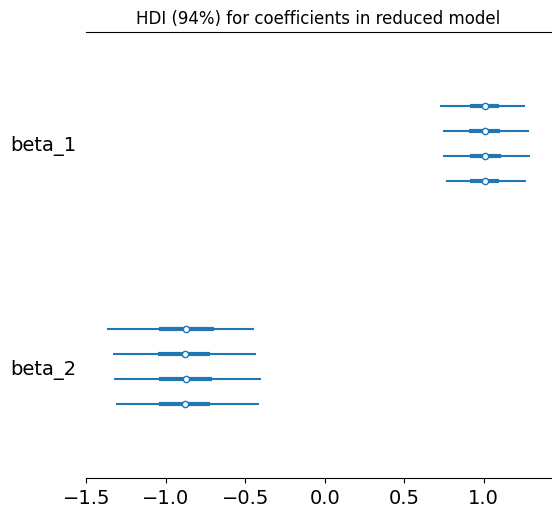

Output()

Output()


Model Comparison Results:
         rank   elpd_waic    p_waic  elpd_diff    weight         se       dse  \
model_l     0  425.028260  5.524178   0.000000  0.915531  25.401877  0.000000   
model_p     1  439.356857  2.898600  14.328596  0.084469  24.513585  9.330159   

         warning     scale  
model_l    False  deviance  
model_p    False  deviance  


In [17]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Read and prepare data
data = pd.read_csv('date_alegeri_turul2.csv')

# Standardize numerical variables
data['Varsta_std'] = (data['Varsta'] - data['Varsta'].mean()) / data['Varsta'].std()
data['Venit_std'] = (data['Venit'] - data['Venit'].mean()) / data['Venit'].std()

# First model with all variables
with pm.Model() as model_l:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    beta_income = pm.Normal('beta_income', mu=0, sigma=10)
    
    mu = intercept + \
         beta_age * data['Varsta_std'] + \
         beta_sex * data['Sex'] + \
         beta_edu * data['Educatie'] + \
         beta_income * data['Venit_std']
    
    theta = pm.math.sigmoid(mu)
    y = pm.Bernoulli('y', p=theta, observed=data['Vot'])
    
    idata_l = pm.sample(draws=2000, tune=1000, return_inferencedata=True)

# Get the two most important variables
summary = az.summary(idata_l)
coef_importance = abs(summary.loc[['beta_age', 'beta_sex', 'beta_edu', 'beta_income'], 'mean'])
top_2_vars = coef_importance.nlargest(2)
var_to_col = {
    'beta_age': 'Varsta_std',
    'beta_sex': 'Sex',
    'beta_edu': 'Educatie',
    'beta_income': 'Venit_std'
}
top_2_cols = [var_to_col[var] for var in top_2_vars.index]

# Reduced model with only top 2 variables
with pm.Model() as model_p:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=10)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10)
    
    mu = intercept + \
         beta_1 * data[top_2_cols[0]] + \
         beta_2 * data[top_2_cols[1]]
    
    theta = pm.math.sigmoid(mu)
    y = pm.Bernoulli('y', p=theta, observed=data['Vot'])
    
    # Sample with more iterations for better HDI estimation
    idata_p = pm.sample(draws=2000, tune=1000, return_inferencedata=True)

# Print summaries
print("\nSummary of reduced model:")
print(az.summary(idata_p, hdi_prob=0.94))

# Plot HDI
plt.figure(figsize=(12, 6))
az.plot_forest(idata_p, hdi_prob=0.94, var_names=['beta_1', 'beta_2'])
plt.title('HDI (94%) for coefficients in reduced model')
plt.show()

# Compare models
with model_l:
    pm.compute_log_likelihood(idata_l)
waic_l = az.waic(idata_l, scale="deviance")

with model_p:
    pm.compute_log_likelihood(idata_p)
waic_p = az.waic(idata_p, scale="deviance")

comparison_df = az.compare(
    {'model_l': idata_l, 'model_p': idata_p},
    method='BB-pseudo-BMA',
    ic="waic",
    scale="deviance"
)

print("\nModel Comparison Results:")
print(comparison_df)